In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import libraries

In [ ]:
%cd /content/drive/MyDrive/iti/NLP/project

/content/drive/MyDrive/iti/NLP/project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize

from sklearn import metrics

## Read Data

In [6]:
df_copy = pd.read_csv("/content/drive/MyDrive/iti/NLP/project/preprocessed files/preprocessed_file_DL.csv", lineterminator='\n', index_col = 0)
df_copy.shape

(147646, 2)

## Deep Learning

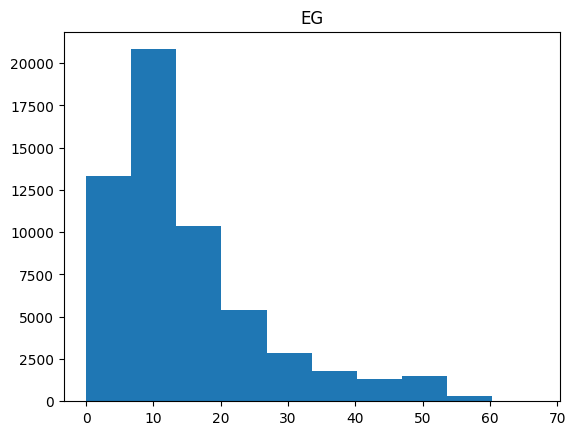

Avg: 14.94703125
Max: 67



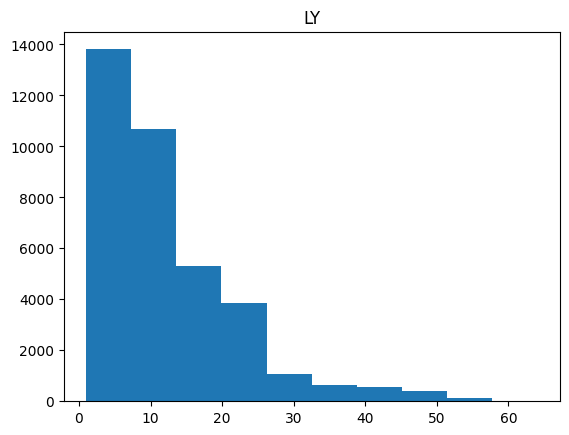

Avg: 12.582438061828546
Max: 64



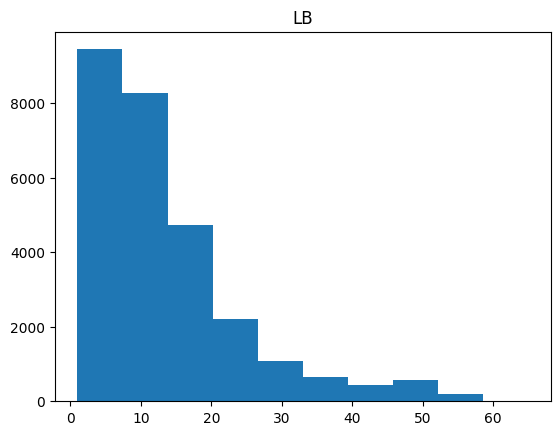

Avg: 13.671387691527512
Max: 65



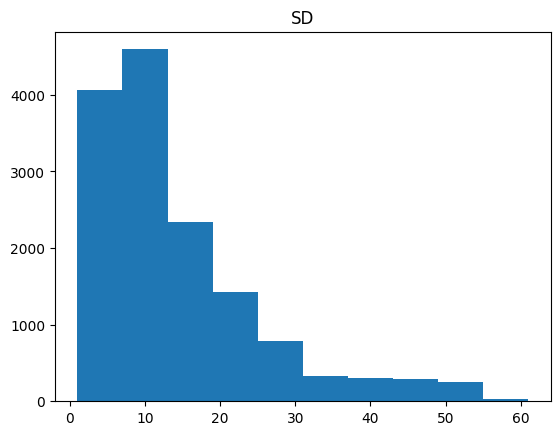

Avg: 13.872824353373552
Max: 61



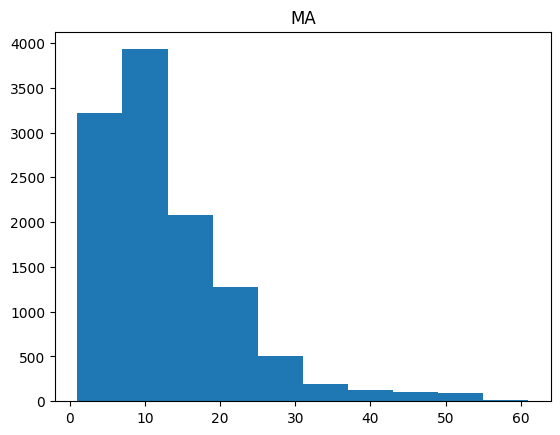

Avg: 12.614397224631396
Max: 61



In [ ]:
def length_plot(data, name):
  length = [len(sentence.split()) for sentence in data]
  plt.hist(length)
  plt.title(name)
  plt.show()
  print(f'Avg: {np.average(length)}')
  print(f'Max: {np.max(length)}\n')

length_plot(df_copy[df_copy["dialect"]=='EG']["text"], "EG")
length_plot(df_copy[df_copy["dialect"]=='LY']["text"], "LY")
length_plot(df_copy[df_copy["dialect"]=='LB']["text"], "LB")
length_plot(df_copy[df_copy["dialect"]=='SD']["text"], "SD")
length_plot(df_copy[df_copy["dialect"]=='MA']["text"], "MA")

In [ ]:
def unq_words(sentence):
  unq_words_list = []
  for sent in (sentence):
    for word in sent.split():
      if word.lower() not in unq_words_list:
        unq_words_list.append(word.lower())
      else:
        pass
  return unq_words_list

unique_words = unq_words(df_copy.text)
print("Total unique words present :", len(unique_words))

Total unique words present : 242779


### GRU Model

In [ ]:
VOC_SIZE = 242779

onehot_vector = [one_hot(words, VOC_SIZE) for words in df_copy.text]
# onehot_vector[0:10]

In [ ]:
words = df_copy['text'].apply(lambda x: text_to_word_sequence(x))

word_to_index = {}
for word_list in words:
    for word in word_list:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

In [ ]:
SENTENCE_LENGTH = 60
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

array([[ 55597,  97567, 138277, ...,      0,      0,      0],
       [241810, 104276, 107953, ...,      0,      0,      0],
       [144513,  80174,   6685, ...,      0,      0,      0],
       ...,
       [ 52219,   1152, 125017, ...,      0,      0,      0],
       [143056, 229726, 119705, ...,      0,      0,      0],
       [   674,  71272, 100691, ...,      0,      0,      0]], dtype=int32)

In [ ]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(embedded_docs, df_copy.dialect, test_size=0.2, random_state=42, stratify=df_copy.dialect)
val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
val_labels = label_encoder.fit_transform(val_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=5)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=5)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=5)

In [ ]:
VECTOR_FEATURES = 128

gru_bi = tf.keras.models.Sequential([    
    tf.keras.layers.Embedding(VOC_SIZE, VECTOR_FEATURES),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
gru_bi.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = gru_bi.fit(train_data, train_labels, epochs=10, batch_size=128,
                    steps_per_epoch= 100,
                    validation_data=(val_data, val_labels),
                    validation_steps=100)

Epoch 1/10
100/100 [==============================] - 37s 239ms/step - loss: 0.4246 - accuracy: 0.4663 - val_loss: 0.2909 - val_accuracy: 0.6698
Epoch 2/10
100/100 [==============================] - 17s 173ms/step - loss: 0.2561 - accuracy: 0.7267 - val_loss: 0.2294 - val_accuracy: 0.7583
Epoch 3/10
100/100 [==============================] - 14s 137ms/step - loss: 0.2194 - accuracy: 0.7650 - val_loss: 0.2029 - val_accuracy: 0.7878
Epoch 4/10
100/100 [==============================] - 12s 117ms/step - loss: 0.2022 - accuracy: 0.7891 - val_loss: 0.1931 - val_accuracy: 0.7987
Epoch 5/10
100/100 [==============================] - 10s 96ms/step - loss: 0.1925 - accuracy: 0.8006 - val_loss: 0.1860 - val_accuracy: 0.8054
Epoch 6/10
100/100 [==============================] - 8s 79ms/step - loss: 0.1813 - accuracy: 0.8150 - val_loss: 0.1793 - val_accuracy: 0.8154
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.1845 - accuracy: 0.8104 - val_loss: 0.1703 - val_accurac

In [ ]:
model_acc, model_loss = gru_bi.evaluate(test_data, test_labels)

print('Test Loss: {}'.format(model_acc))
print('Test Accuracy: {}'.format(model_loss))

462/462 [==============================] - 3s 7ms/step - loss: 0.1724 - accuracy: 0.8326
Test Loss: 0.17238862812519073
Test Accuracy: 0.8325770497322083


In [ ]:
preds_valid = gru_bi.predict(test_data)

pred_labels = np.argmax(preds_valid, axis=-1)

# Convert predicted labels to multilabel-indicator format
pred_labels = label_binarize(pred_labels, classes=np.arange(5))

# Calculate F1 score
f1_macro = f1_score(test_labels, pred_labels, average='macro')

print(f1_macro)

462/462 [==============================] - 3s 5ms/step
0.796362843328673


In [ ]:
gru_bi.save('/content/drive/MyDrive/iti/NLP/project/models/gru_bi.h5') 

### LSTM Model

In [ ]:
SENTENCE_LENGTH = 67
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

array([[ 55597,  97567, 138277, ...,      0,      0,      0],
       [241810, 104276, 107953, ...,      0,      0,      0],
       [144513,  80174,   6685, ...,      0,      0,      0],
       ...,
       [ 52219,   1152, 125017, ...,      0,      0,      0],
       [143056, 229726, 119705, ...,      0,      0,      0],
       [   674,  71272, 100691, ...,      0,      0,      0]], dtype=int32)

In [ ]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(embedded_docs, df_copy.dialect, test_size=0.2, random_state=42, stratify=df_copy.dialect)
val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels)

In [ ]:
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
val_labels = label_encoder.fit_transform(val_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=5)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=5)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=5)

In [ ]:
lstm_bi = tf.keras.models.Sequential([    
    tf.keras.layers.Embedding(VOC_SIZE, VECTOR_FEATURES),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
lstm_bi.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = lstm_bi.fit(train_data, train_labels, epochs=10,
                      steps_per_epoch= 100,
                      validation_data=(val_data, val_labels), 
                      validation_steps=100)

Epoch 1/10
100/100 [==============================] - 38s 300ms/step - loss: 0.4088 - accuracy: 0.4865 - val_loss: 0.2595 - val_accuracy: 0.7240
Epoch 2/10
100/100 [==============================] - 26s 260ms/step - loss: 0.1847 - accuracy: 0.8107 - val_loss: 0.1785 - val_accuracy: 0.8184
Epoch 3/10
100/100 [==============================] - 26s 258ms/step - loss: 0.0935 - accuracy: 0.9140 - val_loss: 0.1882 - val_accuracy: 0.8155
Epoch 4/10
100/100 [==============================] - 23s 230ms/step - loss: 0.0547 - accuracy: 0.9535 - val_loss: 0.2107 - val_accuracy: 0.8129
Epoch 5/10
100/100 [==============================] - 21s 207ms/step - loss: 0.0361 - accuracy: 0.9716 - val_loss: 0.2482 - val_accuracy: 0.8081
Epoch 6/10
100/100 [==============================] - 21s 209ms/step - loss: 0.0266 - accuracy: 0.9799 - val_loss: 0.2639 - val_accuracy: 0.8027
Epoch 7/10
100/100 [==============================] - 19s 194ms/step - loss: 0.0208 - accuracy: 0.9850 - val_loss: 0.2855 - val_ac

In [ ]:
test_loss, test_acc = lstm_bi.evaluate(test_data, test_labels)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

462/462 [==============================] - 3s 6ms/step - loss: 0.3241 - accuracy: 0.7993
Test Loss: 0.3241102695465088
Test Accuracy: 0.7993227243423462


In [ ]:
preds_valid = lstm_bi.predict(test_data)

pred_labels = np.argmax(preds_valid, axis=-1)

# Convert predicted labels to multilabel-indicator format
pred_labels = label_binarize(pred_labels, classes=np.arange(5))

# Calculate F1 score
f1_macro = f1_score(test_labels, pred_labels, average='macro')

print(f1_macro)

462/462 [==============================] - 4s 5ms/step
0.7625189545532873


In [ ]:
lstm_bi.save('/content/drive/MyDrive/iti/NLP/project/models/lstm_bi.h5') 

## Prediction

In [ ]:
## Load the data

rnn_padding = 50
lstm_padding = 61
# word2idx = tf.keras.datasets.imdb.get_word_index()

gru_bi = tf.keras.models.load_model('/content/drive/MyDrive/iti/NLP/project/models/gru_bi.h5')
lstm_bi = tf.keras.models.load_model('/content/drive/MyDrive/iti/NLP/project/models/lstm_bi.h5')

In [ ]:
import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
def predict(text, clf, word2idx, padding_size):
    # padd the text
    padded_text = np.zeros((padding_size))
    # transform your text into indices
    padded_text[:min(padding_size, len(text.split()))] = [
        word_to_index.get(word, 0) for word in text.split()][:padding_size]
    # predict it !
    prediction = clf.predict(tf.expand_dims(padded_text, 0))
    return prediction

In [ ]:
text= "ايه ياسطا"

text = preprocessing.processing(text, 0)

mapping = {"0":"Egypt", "1": "Lebanon", "2": "Libya", "3": "Morocco", "4":"Sindhi"}

print(text)

In [ ]:
out_GRU = predict(text, gru_bi, word_to_index, rnn_padding)

out_GRU = np.argmax(out_GRU)

print(mapping[str(out_GRU)])

1/1 [==============================] - 0s 21ms/step
Egypt


In [ ]:
out_LSTM = predict(text, lstm_bi, word_to_index, lstm_padding)

out_LSTM = np.argmax(out_LSTM)

print(mapping[str(out1)])

1/1 [==============================] - 0s 26ms/step
[[0.07840654 0.03850975 0.818374   0.03025412 0.03445566]]
Libya
